In [171]:
!git clone https://github.com/AhmedSheded/self-driving-car.git

fatal: destination path 'self-driving-car' already exists and is not an empty directory.


In [172]:
!ls self-driving-car

'Behavioural Cloning'   data   finding-lanes   sections


In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras 
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import random
import os
import ntpath
random.seed(2222)

In [174]:
datadir = 'self-driving-car/data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  \
0  /home/sheded/DataspellProjects/self-driving-car/data/IMG/center_2022_09_07_01_51_32_095.jpg   
1  /home/sheded/DataspellProjects/self-driving-car/data/IMG/center_2022_09_07_01_51_32_212.jpg   
2  /home/sheded/DataspellProjects/self-driving-car/data/IMG/center_2022_09_07_01_51_32_334.jpg   
3  /home/sheded/DataspellProjects/self-driving-car/data/IMG/center_2022_09_07_01_51_32_453.jpg   
4  /home/sheded/DataspellProjects/self-driving-car/data/IMG/center_2022_09_07_01_51_32_574.jpg   

                                                                                         left  \
0   /home/sheded/DataspellProjects/self-driving-car/data/IMG/left_2022_09_07_01_51_32_095.jpg   
1   /home/sheded/DataspellProjects/self-driving-car/data/IMG/left_2022_09_07_01_51_32_212.jpg   
2   /home/sheded/DataspellProjects/self-driving-car/data/IMG/left_2022_09_07_01_51_32_334.jpg   
3   /home/sheded/DataspellProjects/self-driving-car/data/IMG/left_2022_09_07_01_51_32_453.jpg   
4   /home/sheded/DataspellProjects/self-driving-car/data/IMG/left_2022_09_07_01_51_32_574.jpg   

                                                                                         right  \
0   /home/sheded/DataspellProjects/self-driving-car/data/IMG/right_2022_09_07_01_51_32_095.jpg   
1   /home/sheded/DataspellProjects/self-driving-car/data/IMG/right_2022_09_07_01_51_32_212.jpg   
2   /home/sheded/DataspellProjects/self-driving-car/data/IMG/right_2022_09_07_01_51_32_334.jpg   
3   /home/sheded/DataspellProjects/self-driving-car/data/IMG/right_2022_09_07_01_51_32_453.jpg   
4   /home/sheded/DataspellProjects/self-driving-car/data/IMG/right_2022_09_07_01_51_32_574.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.000051  
1  0.0       0.0       0.0      0.000050  
2  0.0       0.0       0.0      0.000050  
3  0.0       0.0       0.0      0.000050  
4  0.0       0.0       0.0      0.000050

In [175]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

In [176]:
data.head()

center                              left  \
0  center_2022_09_07_01_51_32_095.jpg  left_2022_09_07_01_51_32_095.jpg   
1  center_2022_09_07_01_51_32_212.jpg  left_2022_09_07_01_51_32_212.jpg   
2  center_2022_09_07_01_51_32_334.jpg  left_2022_09_07_01_51_32_334.jpg   
3  center_2022_09_07_01_51_32_453.jpg  left_2022_09_07_01_51_32_453.jpg   
4  center_2022_09_07_01_51_32_574.jpg  left_2022_09_07_01_51_32_574.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2022_09_07_01_51_32_095.jpg  0.0       0.0       0.0      0.000051  
1  right_2022_09_07_01_51_32_212.jpg  0.0       0.0       0.0      0.000050  
2  right_2022_09_07_01_51_32_334.jpg  0.0       0.0       0.0      0.000050  
3  right_2022_09_07_01_51_32_453.jpg  0.0       0.0       0.0      0.000050  
4  right_2022_09_07_01_51_32_574.jpg  0.0       0.0       0.0      0.000050

In [177]:
data.shape

(5191, 7)

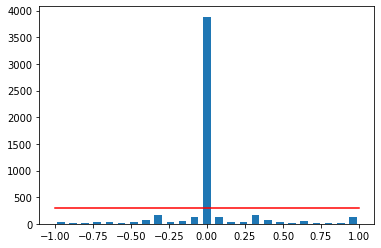

In [178]:
n_pins = 25
samples_ber_bin = 300
hist, bins = np.histogram(data['steering'],n_pins)
center = (bins[:-1]+bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_ber_bin, samples_ber_bin), c='r')

In [179]:
remove_list = []
for j in range(n_pins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_ber_bin:]
  remove_list.extend(list_)

print('total data ', len(data))
print('removed', len(remove_list))
data.drop(data.index[remove_list], inplace =True)
print('remaining data', len(data))

total data  5191
removed 3586
remaining data 1605


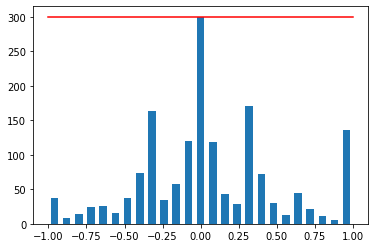

In [180]:
hist, _ = np.histogram(data['steering'], (n_pins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_ber_bin, samples_ber_bin), c='r')

In [181]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(indexed_data[3])
  image_paths = np.asarray(image_path)
  steering = np.asarray(steering)
  return image_paths, steering

image_paths, steering = load_img_steering(datadir+'/IMG', data)

In [182]:
X_train, X_val, y_train, y_val = train_test_split(image_paths, steering, test_size=0.2, random_state=2222)

In [183]:
print(f'Traning samples {len(X_train)}\nValid samples {len(X_val)}')

Traning samples 1284
Valid samples 321


Text(0.5, 1.0, 'Validation set')

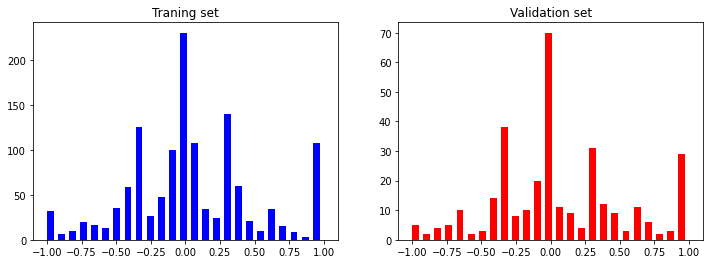

In [184]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4)) 
ax[0].hist(y_train, bins=n_pins, width=0.05, color='b')
ax[0].set_title('Traning set')
ax[1].hist(y_val, bins=n_pins, width=0.05, color='r')
ax[1].set_title('Validation set')

In [185]:
def zoom(img):
  zoom = iaa.Affine(scale=(1, 1.3))
  img = zoom.augment_image(img)
  return img

Text(0.5, 1.0, 'zoomed img')

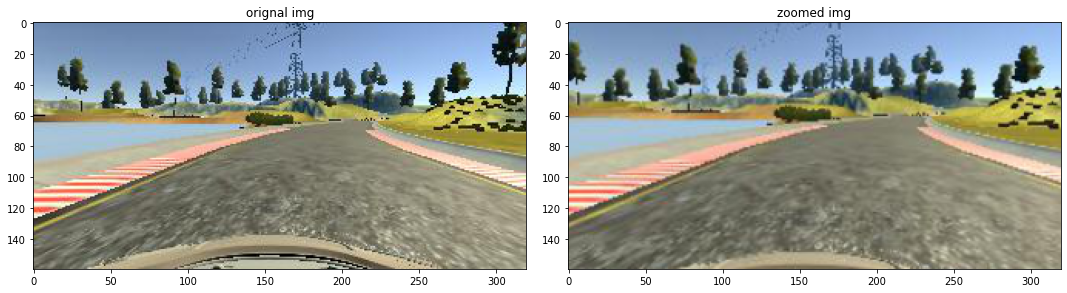

In [186]:
img = image_paths[44]
orignal_img = mpimg.imread(img)
zoomed_img = zoom(orignal_img)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
ax[0].imshow(orignal_img)
ax[0].set_title('orignal img')
ax[1].imshow(zoomed_img)
ax[1].set_title('zoomed img')

In [187]:
def pan(img):
  pan = iaa.Affine(translate_percent={'x':(-0.1, 0.1), 'y': (-0.1, 0.1)})
  img = pan.augment_image(img)
  return img

Text(0.5, 1.0, 'paned img')

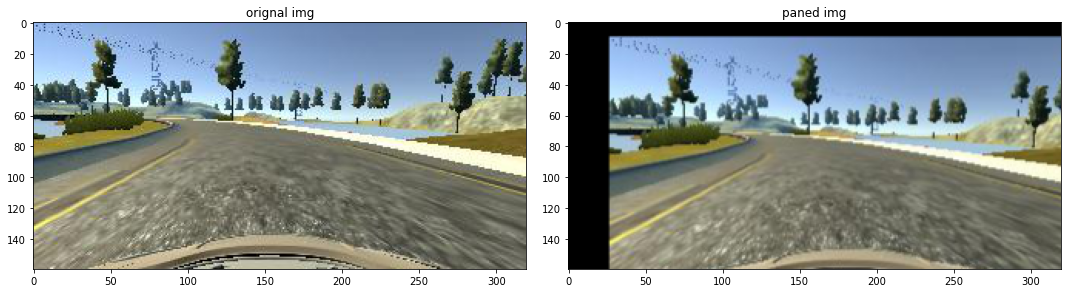

In [188]:
img = image_paths[434]
orignal_img = mpimg.imread(img)
paned_img = pan(orignal_img)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
ax[0].imshow(orignal_img)
ax[0].set_title('orignal img')
ax[1].imshow(paned_img)
ax[1].set_title('paned img')

In [189]:
def img_random_brightness(img):
  brightness = iaa.Multiply((0.2, 1.2))
  img = brightness.augment_image(img)
  return img

Text(0.5, 1.0, 'paned img')

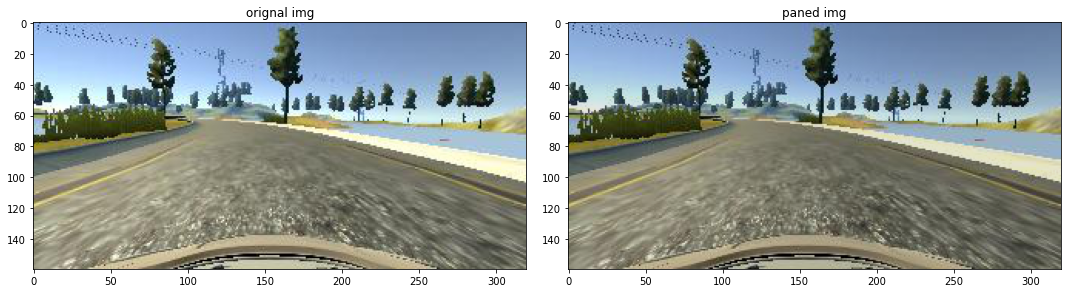

In [190]:
img = image_paths[random.randint(0,len(image_paths))]
orignal_img = mpimg.imread(img)
b_img = img_random_brightness(orignal_img)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
ax[0].imshow(orignal_img)
ax[0].set_title('orignal img')
ax[1].imshow(b_img)
ax[1].set_title('paned img')

In [191]:
def img_flip(img, steering_angle):
  img = cv2.flip(img, 1)
  if steering_angle != 0.0:
    steering_angle = -steering_angle
  return img, steering_angle

Text(0.5, 1.0, 'fliped img - steering angle = 0.09938693')

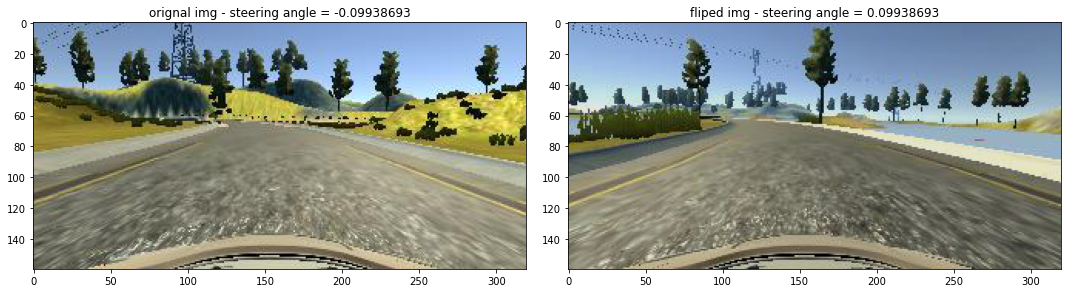

In [192]:
random_index = random.randint(0,len(image_paths)-1)
steering_angle = steering[random_index]
img = image_paths[random_index]
orignal_img = mpimg.imread(img)
img_fliped, angle = img_flip(orignal_img, steering_angle)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
ax[0].imshow(orignal_img)
ax[0].set_title('orignal img - steering angle = '+str(steering_angle))
ax[1].imshow(b_img)
ax[1].set_title('fliped img - steering angle = ' + str(angle))

In [193]:
def random_augment(img, steering_angle):
  img = mpimg.imread(img)
  if np.random.rand() < 0.5:
    img = pan(img)
  if np.random.rand() < 0.5:
    img = zoom(img)
  if np.random.rand() < 0.5:
    img = img_random_brightness(img)
  if np.random.rand() < 0.5:
    img, steering_angle = img_flip(img, steering_angle)
  return img, steering_angle

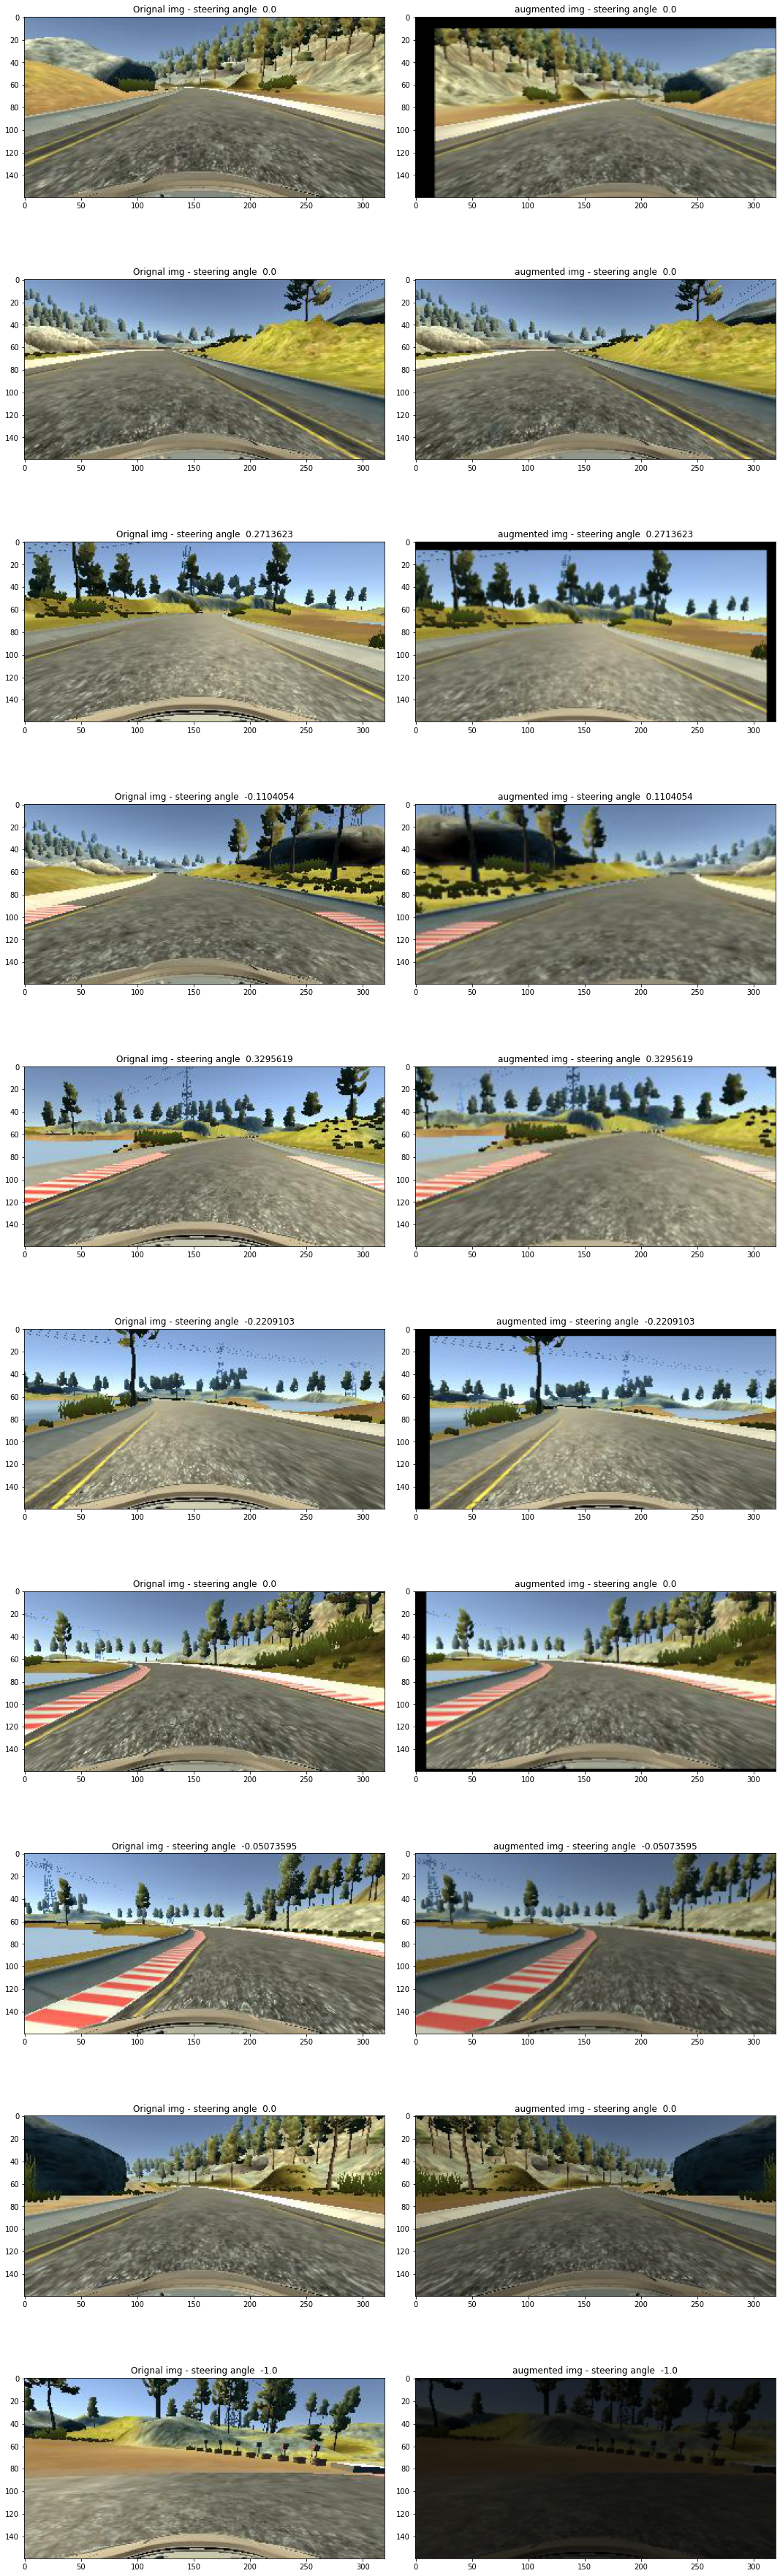

In [194]:
cols = 2
rows = 10
fig, ax = plt.subplots(rows, cols, figsize=(15, 50))
fig.tight_layout()
for i in range(rows):
  randnum = random.randint(0, len(image_paths)-1)
  random_img = image_paths[randnum]
  random_steering = steering[randnum]

  orignal_img = mpimg.imread(random_img)
  augmented_img, angle = random_augment(random_img, random_steering)

  ax[i][0].imshow(orignal_img)
  ax[i][0].set_title('Orignal img - steering angle  '+ str(random_steering))

  ax[i][1].imshow(augmented_img)
  ax[i][1].set_title('augmented img - steering angle  '+ str(angle))

In [195]:
def img_preprocess(img):
  # img = mpimg.imread(img)
  img = img[60:135 :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

In [197]:
# from sklearn import preprocessing
# image = image_paths[100]
# orignal_img = mpimg.imread(image)
# preprocessed_img = img_preprocess(image)

# fig, ax = plt.subplots(1, 2, figsize=(15, 10))
# fig.tight_layout()
# ax[0].imshow(orignal_img)
# ax[0].set_title('Orignal Image')
# ax[1].imshow(preprocessed_img)
# ax[1].set_title('Preprocessed Image')

In [198]:
def batch_generator(img_paths, steering_angle, batch_size, istraning):
  while True:
    batch_img = []
    batch_steering = []
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths)-1)

      if istraning:
        img, angle = random_augment(image_paths[random_index], steering[random_index])
      else:
        img = mpimg.imread(image_paths[random_index])
        angle = steering[random_index]
      img = img_preprocess(img)
      batch_img.append(img)
      batch_steering.append(angle)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'validation image')

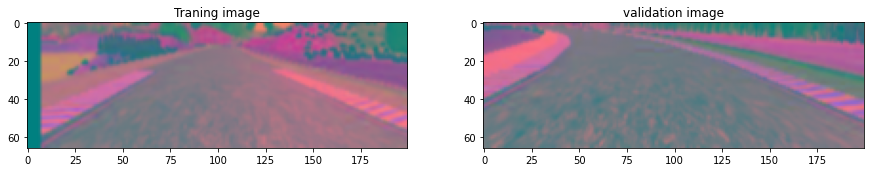

In [199]:
X_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, True))
X_val_gen, y_val_gen = next(batch_generator(X_val, y_val, 1, False))

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(X_train_gen[0])
ax[0].set_title('Traning image')

ax[1].imshow(X_val_gen[0])
ax[1].set_title('validation image')

In [200]:
# X_train = np.array(list(map(img_preprocess, X_train)))
# X_val = np.array(list(map(img_preprocess, X_val)))

In [201]:
# plt.imshow(X_train[random.randint(0, len(X_train-1))])
# plt.axis('off')
# print(X_train.shape)

In [205]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(64, (3, 3), activation='elu'))
  model.add(Conv2D(64, (3, 3), activation='elu')) 
  # model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(50, activation='elu'))
  # model.add(Dropout(0.4))

  model.add(Dense(10, activation='elu'))
  
  model.add(Dense(1))
  model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))
  return model

In [206]:
model = nvidia_model()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_17 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_18 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_19 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 flatten_3 (Flatten)         (None, 1152)              0         
                                                                 
 dense_12 (Dense)            (None, 100)              

In [210]:
history = model.fit_generator(batch_generator(X_train, y_train, batch_size=100, istraning=True),
                              steps_per_epoch=300, epochs=5,
                              validation_data=batch_generator(X_val, y_val, 100, istraning=False),
                              validation_steps=200, verbose=1, shuffle=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/5
300/300 [==============================] - 126s 422ms/step - loss: 0.0890 - val_loss: 0.0700
Epoch 2/5
300/300 [==============================] - 126s 422ms/step - loss: 0.0892 - val_loss: 0.0666
Epoch 3/5
300/300 [==============================] - 126s 421ms/step - loss: 0.0866 - val_loss: 0.0621
Epoch 4/5
300/300 [==============================] - 126s 422ms/step - loss: 0.0855 - val_loss: 0.0630
Epoch 5/5
300/300 [==============================] - 126s 422ms/step - loss: 0.0853 - val_loss: 0.0612


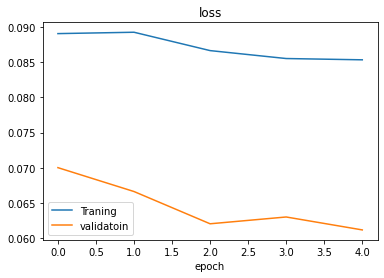

In [211]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Traning', 'validatoin'])
plt.title('loss')
plt.xlabel('epoch')
plt.show()

In [212]:
model.save('modelv2.h5')

In [213]:
from google.colab import files
files.download('modelv2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>